# 모델 알아보기

In [47]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

texts = ["a photo of 2 cats", "a photo of 2 dogs"]
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities
print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")


40.5% that image 0 is 'a photo of 2 cats'


In [ ]:
inputs.keys()

dict_keys(['input_ids', 'pixel_values'])

In [ ]:
inputs.pixel_values.shape

torch.Size([1, 3, 384, 384])

In [29]:
text_inputs = processor.tokenizer(
    texts + ['a photo of 2 cats and 2 dogs with a man in a hat next to them'],
    max_length=10, truncation=True, padding="max_length", return_tensors="pt"
)
text_inputs

{'input_ids': tensor([[ 262,  266, 1304,  267,  454, 6473,    1,    1,    1,    1],
        [ 262,  266, 1304,  267,  454, 3014,    1,    1,    1,    1],
        [ 262,  266, 1304,  267,  454, 6473,  263,  454, 3014,    1]])}

In [54]:
for k, v in outputs.items():
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.shape}")
    else:
        print(f"{k}: {v.pooler_output.shape}")

outputs.logits_per_image, outputs.logits_per_image.sigmoid()

logits_per_image: torch.Size([1, 2])
logits_per_text: torch.Size([2, 1])
text_embeds: torch.Size([2, 1152])
image_embeds: torch.Size([1, 1152])
text_model_output: torch.Size([2, 1152])
vision_model_output: torch.Size([1, 1152])


(tensor([[-0.3843, -9.7228]]), tensor([[4.0509e-01, 5.9897e-05]]))

# 붙이기

In [2]:
import numpy as np
from PIL import Image
from decord import VideoReader

import torch
from torchvision import transforms
from torchvision.transforms._transforms_video import NormalizeVideo, CenterCropVideo
from pytorchvideo import transforms as pv_transforms
from transformers import AutoImageProcessor, AutoModel

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


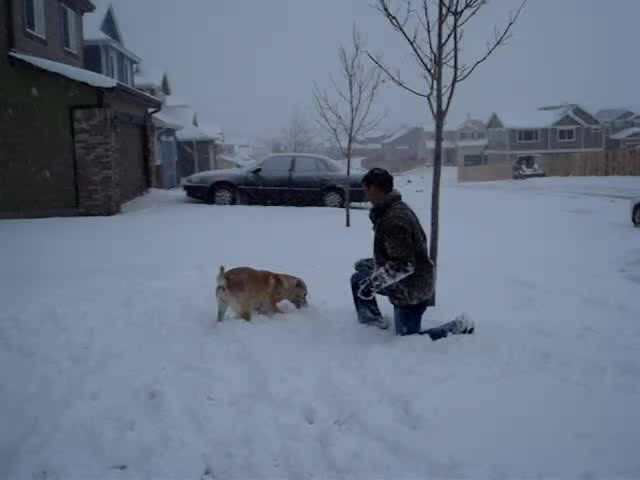

torch.Size([3, 4, 384, 384])


In [41]:
video_transform = transforms.Compose(
    [
        # pv_transforms.ShortSideScale(256),
        # CenterCropVideo(224),
        pv_transforms.ShortSideScale(448),
        CenterCropVideo(384),
        pv_transforms.Div255(),
        NormalizeVideo(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

vr = VideoReader('/code/libs/internvideo/InternVideo2/multi_modality/demo/example1.mp4')
num_frames = len(vr)
frames = vr.get_batch(np.arange(0, num_frames, num_frames // 4)[:4]).asnumpy()
display(Image.fromarray(frames[0]))
frames = torch.from_numpy(frames).float()
frames = video_transform(frames.permute(3, 0, 1, 2))
print(frames.shape)

In [42]:
text_candidates = ["A playful dog and its owner wrestle in the snowy yard, chasing each other with joyous abandon.",
                   "A man in a gray coat walks through the snowy landscape, pulling a sleigh loaded with toys.",
                   "A person dressed in a blue jacket shovels the snow-covered pavement outside their house.",
                   "A pet dog excitedly runs through the snowy yard, chasing a toy thrown by its owner.",
                   "A person stands on the snowy floor, pushing a sled loaded with blankets, preparing for a fun-filled ride.",
                   "A man in a gray hat and coat walks through the snowy yard, carefully navigating around the trees.",
                   "A playful dog slides down a snowy hill, wagging its tail with delight.",
                   "A person in a blue jacket walks their pet on a leash, enjoying a peaceful winter walk among the trees.",
                   "A man in a gray sweater plays fetch with his dog in the snowy yard, throwing a toy and watching it run.",
                   "A person bundled up in a blanket walks through the snowy landscape, enjoying the serene winter scenery."]

In [43]:
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", trust_remote_code=True)
model.eval()

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(32000, 1152)
      (position_embedding): Embedding(64, 1152)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-26): 27 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
            (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
            (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
            (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
          )
          (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=1152, out_features=4304, bias=True)
            (fc2): Linear(in_features=4304, out_features=1152, bias=True)
          )
          (layer_norm2): L

In [96]:
text_inputs = processor.tokenizer(
    text_candidates,
    max_length=64, truncation=True, padding="max_length", return_tensors="pt"
)
text_inputs.input_ids.shape

torch.Size([10, 64])

In [125]:
list(k for k, v in model.named_parameters())

['logit_scale',
 'logit_bias',
 'text_model.embeddings.token_embedding.weight',
 'text_model.embeddings.position_embedding.weight',
 'text_model.encoder.layers.0.self_attn.k_proj.weight',
 'text_model.encoder.layers.0.self_attn.k_proj.bias',
 'text_model.encoder.layers.0.self_attn.v_proj.weight',
 'text_model.encoder.layers.0.self_attn.v_proj.bias',
 'text_model.encoder.layers.0.self_attn.q_proj.weight',
 'text_model.encoder.layers.0.self_attn.q_proj.bias',
 'text_model.encoder.layers.0.self_attn.out_proj.weight',
 'text_model.encoder.layers.0.self_attn.out_proj.bias',
 'text_model.encoder.layers.0.layer_norm1.weight',
 'text_model.encoder.layers.0.layer_norm1.bias',
 'text_model.encoder.layers.0.mlp.fc1.weight',
 'text_model.encoder.layers.0.mlp.fc1.bias',
 'text_model.encoder.layers.0.mlp.fc2.weight',
 'text_model.encoder.layers.0.mlp.fc2.bias',
 'text_model.encoder.layers.0.layer_norm2.weight',
 'text_model.encoder.layers.0.layer_norm2.bias',
 'text_model.encoder.layers.1.self_attn.

In [138]:
# inputs = processor(images=[Image.fromarray(frames[i]) for i in range(2)], return_tensors="pt")
# outputs = model(**inputs)

with torch.inference_mode():
    outputs = model.forward(
        pixel_values=frames.permute(1, 0, 2, 3),
        **text_inputs,
    )
    z_img = model.vision_model.forward(pixel_values=frames.permute(1, 0, 2, 3)).pooler_output
    z_txt = model.text_model.forward(**text_inputs).pooler_output
    z_img /= z_img.norm(dim=-1, keepdim=True)
    z_txt /= z_txt.norm(dim=-1, keepdim=True)

In [132]:
with np.printoptions(precision=5, suppress=True, linewidth=120):
    # print(outputs.logits_per_image.sigmoid().numpy())
    print(outputs.logits_per_image.numpy())

[[  2.47455  -9.3583   -7.39972  -1.68851 -11.35133  -8.95516  -2.88223  -8.00983   0.2905  -12.7132 ]
 [  3.39536 -11.27567  -9.76996  -3.74139 -10.95899 -11.69747  -3.05396  -9.62092  -2.53292 -14.98119]
 [  1.32841  -9.08687  -9.63873  -1.75631 -10.78839 -13.07455  -1.1119  -11.81572  -2.94444 -12.70631]
 [ -0.42684 -10.65075  -7.15489  -2.51097 -12.22768 -10.97321  -0.79435 -10.50802  -5.03841 -13.06498]]


In [100]:
outputs.text_embeds, outputs.text_model_output.pooler_output, outputs.image_embeds, outputs.vision_model_output.pooler_output

(tensor([[ 0.0173,  0.0049,  0.0207,  ..., -0.0095,  0.0164, -0.0033],
         [ 0.0306, -0.0111,  0.0144,  ..., -0.0203,  0.0217,  0.0635],
         [ 0.0148,  0.0211,  0.0330,  ..., -0.0338,  0.0257,  0.0580],
         ...,
         [-0.0043, -0.0052, -0.0365,  ..., -0.0134,  0.0123,  0.0618],
         [ 0.0037, -0.0046,  0.0176,  ..., -0.0035,  0.0226,  0.0537],
         [ 0.0234, -0.0240, -0.0151,  ...,  0.0014,  0.0367,  0.0381]]),
 tensor([[ 0.6131,  0.1726,  0.7350,  ..., -0.3364,  0.5830, -0.1181],
         [ 1.0040, -0.3641,  0.4703,  ..., -0.6653,  0.7097,  2.0817],
         [ 0.5003,  0.7139,  1.1159,  ..., -1.1437,  0.8689,  1.9641],
         ...,
         [-0.1446, -0.1768, -1.2432,  ..., -0.4564,  0.4186,  2.1036],
         [ 0.1276, -0.1587,  0.6031,  ..., -0.1199,  0.7730,  1.8401],
         [ 0.8324, -0.8553, -0.5369,  ...,  0.0513,  1.3076,  1.3559]]),
 tensor([[-0.0125,  0.0200,  0.0005,  ..., -0.0141, -0.0180,  0.0397],
         [-0.0242,  0.0175,  0.0067,  ..., -0

In [101]:
outputs.text_model_output.pooler_output / outputs.text_model_output.pooler_output.norm(dim=-1, keepdim=True)

tensor([[ 0.0173,  0.0049,  0.0207,  ..., -0.0095,  0.0164, -0.0033],
        [ 0.0306, -0.0111,  0.0144,  ..., -0.0203,  0.0217,  0.0635],
        [ 0.0148,  0.0211,  0.0330,  ..., -0.0338,  0.0257,  0.0580],
        ...,
        [-0.0043, -0.0052, -0.0365,  ..., -0.0134,  0.0123,  0.0618],
        [ 0.0037, -0.0046,  0.0176,  ..., -0.0035,  0.0226,  0.0537],
        [ 0.0234, -0.0240, -0.0151,  ...,  0.0014,  0.0367,  0.0381]])

In [121]:
model.logit_scale, model.logit_scale.exp(), model.logit_bias

(Parameter containing:
 tensor([4.72147], requires_grad=True),
 tensor([112.33287], grad_fn=<ExpBackward0>),
 Parameter containing:
 tensor([-16.54642], requires_grad=True))

In [139]:
# print(outputs.vision_model_output.pooler_output @ outputs.text_model_output.pooler_output.T)
torch.set_printoptions(precision=5, sci_mode=False, linewidth=120)
with torch.no_grad():
    print(outputs.logits_per_image)
    print(outputs.image_embeds @ outputs.text_embeds.T)
    print(outputs.image_embeds @ outputs.text_embeds.T * model.logit_scale.exp() + model.logit_bias)
    print(z_img @ z_txt.T * model.logit_scale.exp() + model.logit_bias)

tensor([[  2.47455,  -9.35830,  -7.39972,  -1.68851, -11.35133,  -8.95516,  -2.88223,  -8.00983,   0.29050, -12.71320],
        [  3.39536, -11.27567,  -9.76996,  -3.74139, -10.95899, -11.69747,  -3.05396,  -9.62092,  -2.53292, -14.98119],
        [  1.32841,  -9.08687,  -9.63873,  -1.75631, -10.78839, -13.07455,  -1.11190, -11.81572,  -2.94444, -12.70631],
        [ -0.42684, -10.65075,  -7.15489,  -2.51097, -12.22768, -10.97321,  -0.79435, -10.50802,  -5.03841, -13.06498]])
tensor([[0.16933, 0.06399, 0.08142, 0.13227, 0.04625, 0.06758, 0.12164, 0.07599, 0.14988, 0.03412],
        [0.17752, 0.04692, 0.06032, 0.11399, 0.04974, 0.04317, 0.12011, 0.06165, 0.12475, 0.01393],
        [0.15912, 0.06641, 0.06149, 0.13166, 0.05126, 0.03091, 0.13740, 0.04211, 0.12109, 0.03419],
        [0.14350, 0.05248, 0.08360, 0.12495, 0.03845, 0.04961, 0.14023, 0.05375, 0.10245, 0.03099]])
tensor([[  2.47455,  -9.35830,  -7.39972,  -1.68851, -11.35133,  -8.95516,  -2.88223,  -8.00983,   0.29050, -12.71320]